### Task 1

**Clearly explain why you needed a particular resource for implementing a 2-layer
Neural Network (NN):**

The deep learning framework I will be using is PyTorch.
PyTorch and deep learning frameworks generally utilize GPUs to speed up the
computation of matrix operations (neural networks are essentially a collection
of matrices). Additionally, these frameworks have front-ends allowing users to
declare what kind of feed-forward network model they want. Moreover, they also
contain a back-end to compute the gradient according to some cost function,
which the user can also pick.

To implement a 2-layer NN, I use PyTorch mainly for the reasons mentioned
above. I can implement the 2 layer using the PyTorch modules (which uses
tensors). Also, I can train and optimize this 2-layer NN using PyTorch.
Specifically, I will use Dataset and DataLoader from PyTorch, which is just a
wrapper around my datasets. Additionally, I will use nn.Module, which is where
I can design the network itself. Lastly, I will use functions like nn.BCELoss()
and torch.optim.Adam() as my loss function and optimizer. 

The only resource I need is https://pytorch.org/docs/stable/index.html because
it includes all the documentation for pytorch.

### Task 2

The dataset I will be using comes from here:
https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset. The
goal of this data set is to predict the customer churn for a bank. The dataset
has 10000 data entries, which is a relatively large amount; thus, suitable for
a deep learning model. 


**1. Exploratory Data Analysis**

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

df = pd.read_csv("bank_churn_data.csv")
df

Using cpu device


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Looking at the table above, we can see that the data set includes factors such
as credit score, country, gender, age, balance, and salary. These factors will
be used in the deep learning model. Some factors are not used on purpose so
that the input parameters to the model can be more general. However, this might
be changed later on after evaluating the results. 

Looking below at the statistical breakdown of the data, we can see that the
dataset is nice and balanced: the male-to-female ratio is almost one-half and
there is a wide range for salary, credit score, and age. The only thing lacking
is the countries because there are only 3: France, Germany, and Spain. However,
if this model is used only for banks in those countries, then it would not be
an issue. 

(10000, 6) (10000, 1)
age mean: 38.9218, std: 10.487282048271611
credit_score mean: 650.5288, std: 96.64846595037089
salary mean: 100090.239881, std: 57507.617221165565
percent male: 0.5457
countries: 3


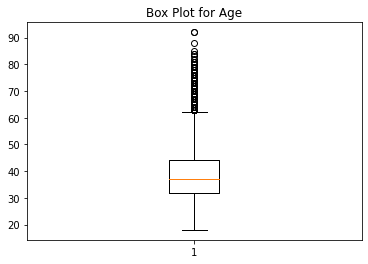

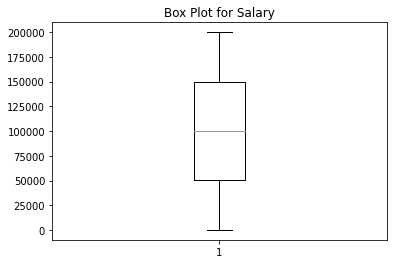

In [15]:
def norm(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))

def metric(pred, act):
    assert(pred.shape[0] == act.shape[0])
    N = pred.shape[0]   
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for n in range(N):
        if (pred[n] ==  1 and act[n] == 1):
            tp += 1
        if (pred[n] == 0 and act[n] == 0):
            tn += 1
        if(pred[n] == 1 and act[n] == 0):
            fp += 1
        if(pred[n] == 0 and act[n] == 1):
            fn += 1
    acc = (tp + tn)/(tp + tn + fp + fn)
    prec = (tp)/(tp + fp)
    rec = (tp)/(tp + fn) 
    return (acc, prec, rec)

gender = norm(np.asarray([df["gender"] == "Male"], dtype=np.float64))
credit_score = norm(np.asarray(df["credit_score"], dtype=np.float64))
age = norm(np.asarray(df["age"], dtype=np.float64))
balance = norm(np.asarray(df["balance"], dtype=np.float64))
credit_score = norm(np.asarray(df["credit_score"], dtype=np.float64))
salary = norm(np.asarray(df["estimated_salary"], dtype=np.float64))

country_dict = {}
id = 0
for c in df["country"]:
    if not c in country_dict.keys():
        id += 1
        country_dict[c] = id
countries = norm(np.asarray([country_dict[c] for c in df["country"]], dtype=np.float64))

bank_data = np.vstack((credit_score, countries, gender, age, balance, salary)).T
bank_churn = np.asarray([df["churn"]], dtype=np.float64).T
print(bank_data.shape, bank_churn.shape)

print("age mean: {}, std: {}".format(np.mean(df["age"]), np.std(df["age"])))
print("credit_score mean: {}, std: {}".format(np.mean(df["credit_score"]), np.std(df["credit_score"])))
print("salary mean: {}, std: {}".format(np.mean(df["estimated_salary"]), np.std(df["estimated_salary"])))
print("percent male: {}".format(np.mean(gender)))
print("countries: {}".format(len(country_dict)))

plt.figure(1)
plt.title("Box Plot for Age")
plt.boxplot(df["age"])
plt.figure(2)
plt.title("Box Plot for Salary")
plt.boxplot(df["estimated_salary"])
plt.show()

**2. Perform a train-dev-test split**

Below, I split the training data into train, validation, and test sets.
Additionally, I also create a BasicLoader class, which is just a basic
dataloader. That is then applied to all the datasets. 

In [16]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class BasicLoader(Dataset):
   def __init__(self, x, y):
      self.X = torch.Tensor(x)
      self.Y = torch.Tensor(y)
      assert(self.X.shape[0] == self.Y.shape[0])

   def __len__(self):
      return self.X.shape[0]
      
   def __getitem__(self, index):
      return self.X[index], self.Y[index]


# split data into 50% train 25% val 25% test
train_bank_data, test_bank_data, train_bank_churn, test_bank_churn = \
   train_test_split(bank_data, bank_churn, test_size=.25, random_state=30)
train_bank_data, val_bank_data, train_bank_churn, val_bank_churn = \
   train_test_split(train_bank_data, train_bank_churn, test_size=.3333, random_state=30)

train_data_set = BasicLoader(train_bank_data, train_bank_churn)
val_data_set = BasicLoader(val_bank_data, val_bank_churn)
test_data_set = BasicLoader(test_bank_data, test_bank_churn)

train_data_loader = DataLoader(train_data_set, batch_size=100, shuffle=True)
val_data_loader = DataLoader(val_data_set, batch_size=100, shuffle=True)
test_data_loader = DataLoader(test_data_set, batch_size=100, shuffle=True)

**3. Implement forward propagation**

Below, I implement the network and forward propogation. The NN class takes two
parameters which are the size of the inner 2 layers. These are the
hyperparameters for the network.

In [17]:
from torch import nn 

class NN(nn.Module):
    def __init__(self, hl1, hl2):
        super(NN, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(6, hl1),
            nn.ReLU(),
            nn.Linear(hl1, hl2),
            nn.ReLU(),
            nn.Linear(hl2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

model = NN(200, 200).to(device)
epochs = 500
learning_rate = .001

**4. Compute the final cost function.** 

Below, I implement the cost function that will be used. In PyTorch, it is just
one line. I am using binary cross entropy loss because the take is a binary
classification task.

In [18]:
loss_fn = nn.BCELoss()

**5. Implement gradient descent**

In the train_loop below, I implement gradient descent, which would be called a
number of times equal to the total epoch count. The optimizer I choose to use
Adam because of its adaptive learning rate and because it is computationally
efficient. 

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_loop(data_loader, model, loss_fn, optimizer):
    N = len(data_loader.dataset)
    total_loss = 0
    for batch, (x, y) in enumerate(data_loader):
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # if batch % 100 == 0:
        #     print(f"train loss {format(loss.item())}")
    return total_loss/len(data_loader)

def test_loop(data_loader, model, loss_fn):
    N = len(data_loader.dataset)
    batch_size = len(data_loader)
    loss, correct = 0, 0
    
    with torch.no_grad():
        for x, y in data_loader:
            pred = model(x)
            loss += loss_fn(pred, y).item()
            correct += torch.sum((pred > .5) == y)
    loss = loss / batch_size
    correct = correct/N
    # print(f"test loss: {loss}")
    return loss, correct

**6. Present the results using the test set.**

Here I actually run the train_loop for the number of epochs. I also calculate
the validation loss for each epoch and then display the average. After the
loop, I test the model on the test set and display the results. Additionally, I
plot the train error for each epoch iteration, and you can see that the error
continually decreases.

train results: 0.34281361281871797, correct: 0.8557999730110168
avg val loss: 0.4205130122160912
test results: 0.47714053869247436, correct: 0.8080000281333923
accuracy: 80.80000000000001%
precision: 58.56697819314641%
recall: 35.14018691588785%


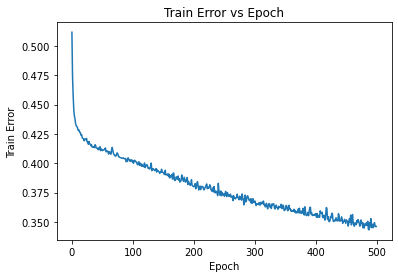

In [20]:
loss = 0
train_losses = []
for i in range(epochs):
    train_loss = train_loop(train_data_loader, model, loss_fn, optimizer)
    l, _ = test_loop(val_data_loader, model, loss_fn)
    train_losses.append(train_loss)
    loss += l
train_loss, train_correct = test_loop(train_data_loader, model, loss_fn)
test_loss, test_correct = test_loop(test_data_loader, model, loss_fn)

print(f"train results: {train_loss}, correct: {train_correct}")
print(f"avg val loss: {loss/epochs}")
print(f"test results: {test_loss}, correct: {test_correct}")
acc, prec, rec =metric(np.asarray(model(test_data_set.X) > .5, dtype=np.float64), test_data_set.Y)
print("accuracy: {}%".format(acc*100))
print("precision: {}%".format(prec*100))
print("recall: {}%".format(rec*100))
plt.title("Train Error vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.plot(train_losses)
plt.show()

After tuning the hyperparameters manually for some time, I chose the ones
listed below. They resuled in higher in sample error, but lower out of sample
error, hinting that the model is more generalized. 

train results: 0.37970831274986266, correct: 0.8379999995231628
avg val loss: 0.41541139003932465
test results: 0.44102839469909666, correct: 0.8123999834060669
accuracy: 81.24%
precision: 63.52459016393443%
recall: 28.971962616822427%


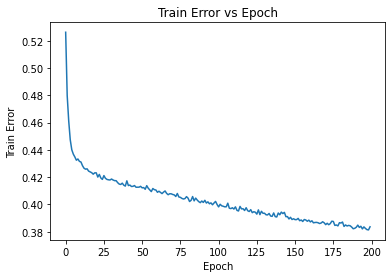

In [21]:
model = NN(140, 140).to(device) # was (200, 200)
learning_rate = .001 # same
epochs = 200 # was 500
loss_fn = nn.BCELoss() # same
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # same
train_losses = []

loss = 0
for i in range(epochs):
    train_loss = train_loop(train_data_loader, model, loss_fn, optimizer)
    l, _ = test_loop(val_data_loader, model, loss_fn)
    train_losses.append(train_loss)
    loss += l
train_loss, train_correct = test_loop(train_data_loader, model, loss_fn)
test_loss, test_correct = test_loop(test_data_loader, model, loss_fn)

print(f"train results: {train_loss}, correct: {train_correct}")
print(f"avg val loss: {loss/epochs}")
print(f"test results: {test_loss}, correct: {test_correct}")
acc, prec, rec =metric(np.asarray(model(test_data_set.X) > .5, dtype=np.float64), test_data_set.Y)
print("accuracy: {}%".format(acc*100))
print("precision: {}%".format(prec*100))
print("recall: {}%".format(rec*100))
plt.title("Train Error vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.plot(train_losses)
plt.show()

The code below does a grid search in 1 dimension for the optimal number of
epochs to use that would have the lowest validation error. Looking at the
graph, we can see at first that the validation error decreases as the epochs
increases; however, after a certain point, the validation error starts to
increase, meaning that the epoch number is too high and we are starting to
overfit. 

In [22]:
import time

step = 25
epochs = np.arange(step, 500, 25)
print(f"epochs: {epochs}")
val_losses = []
times = []

for epoch in epochs:
    # print(f"training for {epoch}")
    model = NN(200, 200).to(device) # same
    learning_rate = .001 # same
    loss_fn = nn.BCELoss() # same
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # same
    start = time.time()
    for i in range(epoch):
        train_loop(train_data_loader, model, loss_fn, optimizer)
        l, _ = test_loop(val_data_loader, model, loss_fn)
        loss += l
    times.append(time.time() - start)
    val_losses.append(loss/epoch)

epochs: [ 25  50  75 100 125 150 175 200 225 250 275 300 325 350 375 400 425 450
 475]


Optimal epochs: 100


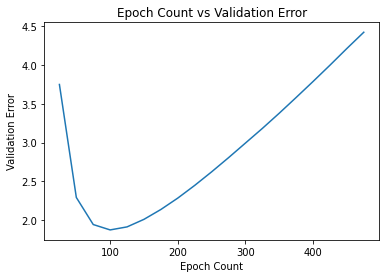

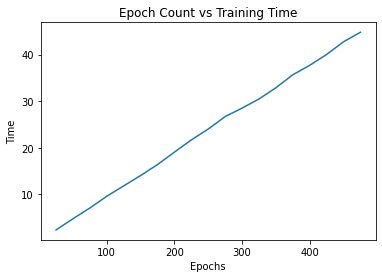

In [23]:
plt.figure(1)
plt.title("Epoch Count vs Validation Error")
plt.xlabel("Epoch Count")
plt.ylabel("Validation Error")
plt.plot(epochs, val_losses)

plt.figure(2)
plt.title("Epoch Count vs Training Time")
plt.xlabel("Epochs")
plt.ylabel("Time")
plt.plot(epochs, times)


print(f"Optimal epochs: {epochs[np.argmin(val_losses)]}")

### Task 3

**Describe how you selected the hyperparameters.**

At first, I selected the values for hyperparameters by researching what common
starting values are. For example, a learning rate of 0.001 is typical for Adam,
and 200 nodes for each inner layer is a good starting point. The number of
epochs I chose at the start was 500 because it seemed like a good choice; there
was no strict rationale for that. After selecting all the starting parameters,
I started tuning them. My process for tuning the hyperparameters was manually
done: I trained the model, inspected the validation error only, then adjusted
the parameters accordingly. There are more sophisticated ways, such as a grid
search, which automates the process and tunes much finer. I implemented this
for choosing the optimal number of epochs. In the graph above, you can see a
minimum in error that corresponds to the optimal number of epochs, which is
what I would choose to use. In the end, I changed the inner layers to use 140
nodes each and changed the number of epochs from 500 to 200. This change in
hyperparameters improved test results from 79.6% to 81.3%.


**What was the rationale behind the technique you used?**

There are two primary purposes for selecting hyperparameters. The first is to
increase efficiency in training the model. In my case, the hyperparameter that
corresponds to this is the learning rate. Since I used the Adam optimizer, it
was not too important to tune the learning rate myself, as the Adam optimizer
automatically adapts it to the learning conditions. The second purpose for
selecting hyperparameters is to reduce overfitting and increase accuracy on
out-of-sample data. To do this, as mentioned above, I only paid attention to
the validation error and manually adjusted the epoch count and layer size.
Additionally, I also implemented a one-dimensional grid search for the number
of epochs, which you can see in the graph above. 

**Did you use regularization? Why, or why not?**

Yes, I used regularization. At first, my model used 500 epochs and 200 nodes in
each inner layer. As a result, the model was overfitting to the data. To fix
this, I needed to use regularization. For NN, one form of regularization is
early stopping. To do this, I simply reduced the number of epochs used. Looking
at the graph above, you can see that this is an effective form of
regularization as there is an optimal number of epochs. Another form of
regularization I used was reducing the overall complexity of the model. The NN
started out with 200 nodes in each inner layer. To reduce complexity, I simply
reduced the number of nodes in the inner layers ( I went from 200 to 140). This
is a form of regularization because the neural network has fewer parameters to
use. After regularizing the model, I increased the accuracy of the model using
out-of-sample data. 

**Did you use an optimization algorithm? Why or why not?**

Yes, I used an optimization algorithm. Using regular gradient descent on 10,000
points of data would take way too long. At first, I used stochastic gradient
descent, but upon looking at the error plot, it was too sporadic and not
correctly "converging." As a result, I switched to using the Adam optimizer.
The error plot was much cleaner, and I got better results. Also, by using the
Adam optimizer, I did not have to worry about perfecting the learning rate
hyperparameter as Adam is adaptive.


### Task 4

**Create another baseline model. Using the same training data (as above) train your model and evaluate results using the test set.**

The baseline model I will use to compare against the neural network is a simple logistic regression model.

train results: 0.448047451376915, correct: 0.79339998960495
avg val loss: 0.45151624661684
test results: 0.4592009961605072, correct: 0.7807999849319458
accuracy: 78.08%
precision: 44.537815126050425%
recall: 9.906542056074766%


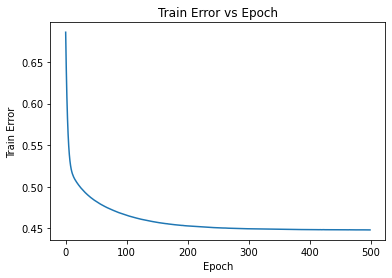

In [24]:
class LR(torch.nn.Module):
    def __init__(self, inputs):
        super().__init__()
        self.linear = torch.nn.Linear(inputs, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))
    
model = LR(6).to(device) 
learning_rate = .001
epochs = 500
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # same
train_losses = []

loss = 0
for i in range(epochs):
    train_loss = train_loop(train_data_loader, model, loss_fn, optimizer)
    l, _ = test_loop(val_data_loader, model, loss_fn)
    train_losses.append(train_loss)
    loss += l
train_loss, train_correct = test_loop(train_data_loader, model, loss_fn)
test_loss, test_correct = test_loop(test_data_loader, model, loss_fn)

print(f"train results: {train_loss}, correct: {train_correct}")
print(f"avg val loss: {loss/epochs}")
print(f"test results: {test_loss}, correct: {test_correct}")
acc, prec, rec = metric(np.asarray(model(test_data_set.X) > .5, dtype=np.float64), test_data_set.Y)
print("accuracy: {}%".format(acc*100))
print("precision: {}%".format(prec*100))
print("recall: {}%".format(rec*100))
plt.title("Train Error vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.plot(train_losses)
plt.show()

**What are the reasons for one model performing better (or not) than the other? Explain.**

Looking at the results, we can see that the logistic regression model performed
worse. First, the in-sample error for the logistic regression model is worse.
One reason for this is that logistic regression may be too simple a model to
learn the patterns in the data correctly. Moreover, the logistic regression
model with six inputs has significantly fewer tunable parameters than a neural
network with two inner layers containing several nodes. Second, the
out-of-sample error for the logistic regression is also worse. I hypothesized
that perhaps the out-of-sample error for logistic regression might be better,
but since it underfitted overall, it was still bad. In contrast, the
out-of-sample error for the neural network was much better even though it is
much easier to overfit; steps can be taken to regularize to avoid overfitting.